In [1]:
# training a classic model on the Speechcommands dataset
# adapted from https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html

In [2]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8.0, 6.0)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

In [4]:
import IPython.display as ipd
from tqdm.notebook import tqdm

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# from torchaudio.datasets import SPEECHCOMMANDS
# import os

# class SubsetSC(SPEECHCOMMANDS):
#     def __init__(self, subset: str = None):
#         super().__init__('/home/data/torchaudio-SPEECHCOMMANDS/', download=False)

#         def load_list(filename):
#             filepath = os.path.join(self._path, filename)
#             with open(filepath) as fileobj:
#                 return [os.path.join(self._path, line.strip()) for line in fileobj]

#         if subset == 'validation':
#             self._walker = load_list('validation_list.txt')
#         elif subset == 'testing':
#             self._walker = load_list('testing_list.txt')
#         elif subset == 'training':
#             excludes = load_list('validation_list.txt') + load_list('testing_list.txt')
#             excludes = set(excludes)
#             self._walker = [w for w in self._walker if w not in excludes]


# # Create training and testing split of the data. We do not use validation in this tutorial.
# train_set = SubsetSC('training')
# test_set = SubsetSC('testing')



In [7]:
import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [8]:
# load dataset
(train_loader, val_loader, test_loader) = fgnh.SpeechCommands_Dataloaders(resample_rate = 8000,
                                                                          batch_size = 32,
                                                                          batchsize_for_val =32,
                                                                          num_workers=5, 
                                                                          pin_memory=True)

In [9]:
train_set = train_loader.dataset
test_set = test_loader.dataset
waveform, sample_rate, label, speaker_id, utterance_number = test_set[548]

Shape of waveform: torch.Size([1, 6826])
Sample rate of waveform: 16000


<IPython.core.display.Javascript object>


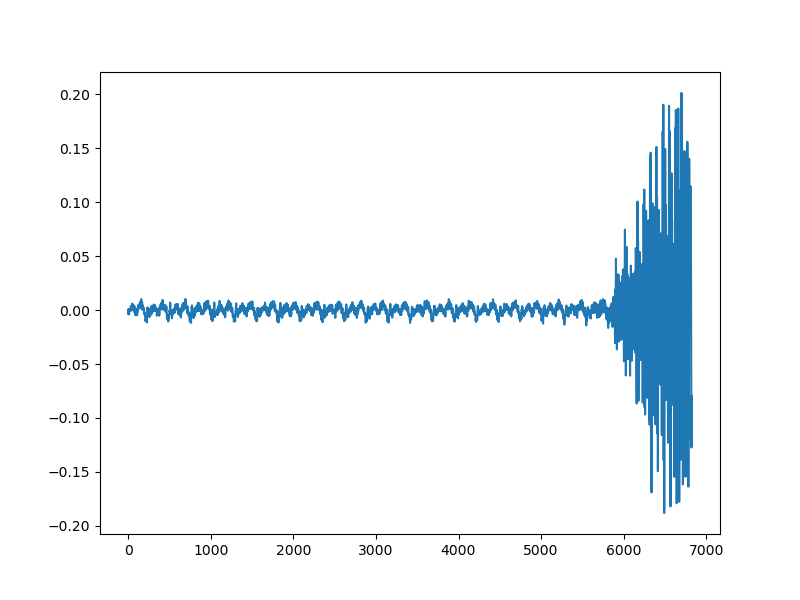

In [10]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())
plt.show()

In [11]:
# labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

In [12]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [13]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [14]:
# def pad_sequence(batch):
#     # Make all tensor in a batch the same length by padding with zeros
#     batch = [item.t() for item in batch]
#     batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
#     return batch.permute(0, 2, 1)


# def collate_fn(batch):

#     # A data tuple has the form:
#     # waveform, sample_rate, label, speaker_id, utterance_number

#     tensors, targets = [], []

#     # Gather in lists, and encode labels as indices
#     for waveform, _, label, *_ in batch:
#         tensors += [waveform]
#         targets += [label_to_index(label)]

#     # Group the list of tensors into a batched tensor
#     tensors = pad_sequence(tensors)
#     targets = torch.stack(targets)

#     return tensors, targets


# batch_size = 256

# if device == "cuda":
#     num_workers = 1
#     pin_memory = True
# else:
#     num_workers = 0
#     pin_memory = False

# train_loader = torch.utils.data.DataLoader(
#     train_set,
#     batch_size=batch_size,
#     shuffle=True,
#     collate_fn=collate_fn,
#     num_workers=num_workers,
#     pin_memory=pin_memory,
# )
# test_loader = torch.utils.data.DataLoader(
#     test_set,
#     batch_size=batch_size,
#     shuffle=False,
#     drop_last=False,
#     collate_fn=collate_fn,
#     num_workers=num_workers,
#     pin_memory=pin_memory,
# )

In [15]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [16]:
model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

/home/felix/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:125: UserWarning: 
GeForce RTX 2080 Ti with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the GeForce RTX 2080 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [18]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [19]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [20]:
log_interval = 20
n_epoch = 21

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
# transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.857143
Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.127137
Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.614116
Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.321233
Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.134231
Train Epoch: 1 [25600/84843 (30%)]	Loss: 2.035896
Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.740669
Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.584017
Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.687515
Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.461402
Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.356395
Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.291308
Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.223220
Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.128469
Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.379704
Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.007297
Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.080638

Test Epoch: 1	Accuracy: 7472/11005 (68%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.106001
Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.029865
Train Epoch: 2 [10240

Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.621037
Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.565842
Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.430674
Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.580813
Train Epoch: 10 [46080/84843 (54%)]	Loss: 0.605686
Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.454098
Train Epoch: 10 [56320/84843 (66%)]	Loss: 0.606291
Train Epoch: 10 [61440/84843 (72%)]	Loss: 0.522108
Train Epoch: 10 [66560/84843 (78%)]	Loss: 0.589662
Train Epoch: 10 [71680/84843 (84%)]	Loss: 0.577027
Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.525493
Train Epoch: 10 [81920/84843 (96%)]	Loss: 0.538357

Test Epoch: 10	Accuracy: 8740/11005 (79%)

Train Epoch: 11 [0/84843 (0%)]	Loss: 0.575581
Train Epoch: 11 [5120/84843 (6%)]	Loss: 0.574655
Train Epoch: 11 [10240/84843 (12%)]	Loss: 0.616339
Train Epoch: 11 [15360/84843 (18%)]	Loss: 0.625071
Train Epoch: 11 [20480/84843 (24%)]	Loss: 0.430348
Train Epoch: 11 [25600/84843 (30%)]	Loss: 0.490056
Train Epoch: 11 [30720/84843 (36%)]	Loss: 0.4

Train Epoch: 19 [35840/84843 (42%)]	Loss: 0.484958
Train Epoch: 19 [40960/84843 (48%)]	Loss: 0.531762
Train Epoch: 19 [46080/84843 (54%)]	Loss: 0.504305
Train Epoch: 19 [51200/84843 (60%)]	Loss: 0.446895
Train Epoch: 19 [56320/84843 (66%)]	Loss: 0.381960
Train Epoch: 19 [61440/84843 (72%)]	Loss: 0.450494
Train Epoch: 19 [66560/84843 (78%)]	Loss: 0.628065
Train Epoch: 19 [71680/84843 (84%)]	Loss: 0.519608
Train Epoch: 19 [76800/84843 (90%)]	Loss: 0.630867
Train Epoch: 19 [81920/84843 (96%)]	Loss: 0.465815

Test Epoch: 19	Accuracy: 9152/11005 (83%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 0.488517
Train Epoch: 20 [5120/84843 (6%)]	Loss: 0.498656
Train Epoch: 20 [10240/84843 (12%)]	Loss: 0.601076
Train Epoch: 20 [15360/84843 (18%)]	Loss: 0.532379
Train Epoch: 20 [20480/84843 (24%)]	Loss: 0.563319
Train Epoch: 20 [25600/84843 (30%)]	Loss: 0.348652
Train Epoch: 20 [30720/84843 (36%)]	Loss: 0.589680
Train Epoch: 20 [35840/84843 (42%)]	Loss: 0.564485
Train Epoch: 20 [40960/84843 (48%)]	Loss: 0.4

<IPython.core.display.Javascript object>


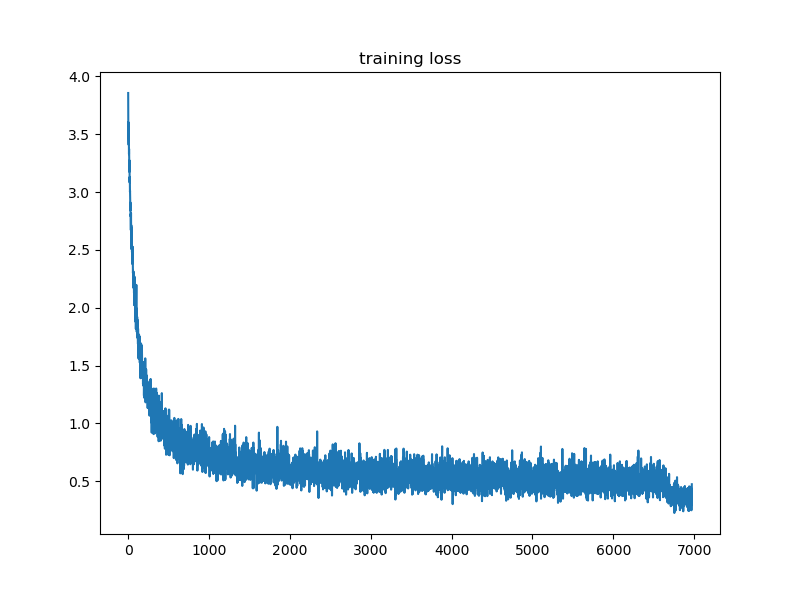

In [21]:
# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")
plt.show()

In [22]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [23]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
#     tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: four. Predicted: happy.


In [24]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_loader.dataset):
    try:
        output = predict(waveform)
        if output != utterance:
            ipd.Audio(waveform.numpy(), rate=sample_rate)
            print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
            break
        else:
            print("All examples in this dataset were correctly classified!")
            print("In this case, let's just look at the last data point")
            ipd.Audio(waveform.numpy(), rate=sample_rate)
            print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
    except:
        # model fails on short wav because of no padding
        print('{} failed'.format(i))
        print(waveform.size())

Data point #0. Expected: right. Predicted: left.


In [25]:
# ### save model
# model_name = 'sample_classic_model_SPEECHCOMMANDS'
# save_path = '../Experiments/sample_SPEECHCOMMANDS_models/'
# print('Saving trained model {} in {}'.format(model_name, save_path))

# # save model entirely
# torch.save(model, save_path+model_name+'_full.pth')

# # save model weights
# torch.save(model.state_dict(), save_path+model_name+'_state_dict.pth')



Saving trained model sample_classic_model_SPEECHCOMMANDS in ../Experiments/sample_SPEECHCOMMANDS_models/
